In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
sns.set_palette(sns.color_palette('Set2')[::2])
sns.set_context('paper', font_scale=1.5)

heatmap_cmap = 'GnBu'

import scipy
from scipy.stats import ttest_rel, beta, ttest_ind
from sklearn.cluster import KMeans
import numpy as np
import os
import yaml
import shutil
from collections import OrderedDict

from utils import quick_load_experiments_tsv, get_significance_by_column, add_probing_location_better_column
from common import lang2code, code2lang, lang2family, family2langs

figure_dir = "fig/tokenization"
os.makedirs("fig", exist_ok=True)
os.makedirs(figure_dir, exist_ok=True)

np.random.seed(2)

%load_ext autoreload
%autoreload 2

%matplotlib inline

# Load data

In [17]:
exps = pd.read_table("../dataframes/exps.tsv", sep="\t", quoting=3)
exps['tag'] = exps['task'].apply(lambda t: t.split("_")[0])
exps['pos'] = exps['task'].apply(lambda t: t.split("_")[1])
exps['full_task'] = exps['language'] + ' ' + exps['task']
exps['family'] = exps['language'].apply(lambda l: lang2family[l])

In [18]:
exps = add_probing_location_better_column(exps)

## Load fertility and majority baseline

In [19]:
fertility = pd.read_table("../dataframes/task_fertility.tsv")
fertility.shape

(319, 14)

In [20]:
old_len = len(exps)

exps = exps.merge(fertility, on=['language', 'task'], how='inner')

if old_len != len(exps):
    raise ValueError(f"Merging with fertility dataframe changed the number of rows: {old_len} --> {len(exps)}")

# Perturbations

In [26]:
data_perturbations = []
model_perturbations = [

    'mBERT-rand-subw', 

]
baseline_models = []

# Model perturbations

In [27]:
models = ['mBERT'] + model_perturbations + baseline_models

baselines = exps[
    ((exps.model.isin(baseline_models)) & (exps.perturbation.isnull())) |
    ((exps.model=='mBERT') & (exps.perturbation.isnull())) |
    ((exps.model=='mBERT') & (exps.perturbation.isin(model_perturbations)))
]
baselines = baselines[baselines['probing_location_better']==True].copy()

In [28]:
baselines['model2'] = None

baselines.loc[(baselines['model']=='mBERT') & (baselines['perturbation'].isnull()), 'model2'] = 'mBERT'
baselines.loc[(baselines['model']=='mBERT') & (baselines['perturbation'].isin(model_perturbations)), 'model2'] = \
    baselines.loc[(baselines['model']=='mBERT') & (baselines['perturbation'].isin(model_perturbations)), 'perturbation']
baselines.loc[((baselines.model.isin(baseline_models)) & (baselines.perturbation.isnull())), 'model2'] = \
    baselines.loc[((baselines.model.isin(baseline_models)) & (baselines.perturbation.isnull())), 'model']

In [29]:
baselines['model'] = baselines['model2']

In [30]:
if set(baselines['model'].unique()) != set(models):
    raise ValueError(f"Models missing from data?\n{baselines['model'].unique()} vs. {models}")

In [31]:
set(models) - set(baselines['model'].unique())

set()

In [32]:
b = baselines.groupby(['model', 'language', 'task'])[['dev_acc', 'test_acc']].mean()
b.name = 'test_acc'
b = b.reset_index()
means = b.groupby('model').mean().sort_values('test_acc')
means / means.loc['mBERT']

,dev_acc,test_acc
model,,
mBERT-rand-subw,0.821162,0.807805
mBERT,1.000000,1.000000


In [33]:
d = b.pivot_table(index=['language', 'task'], columns='model', values='test_acc')

In [34]:
b = baselines.groupby(['model', 'language', 'task'])[['dev_acc', 'test_acc']].mean()
b.name = 'test_acc'
b = b.reset_index()
b['pos'] = b['task'].apply(lambda t: t.split('_')[1])
#b = b[b.model.isin(keep_models)]

all_mean = b.groupby('model').mean().reset_index()
all_mean['pos'] = 'ALL'

b = b.groupby(['model', 'pos']).mean().reset_index()

b = pd.concat((b, all_mean))
b.pos = b.pos.str.upper()

pos_order = ['ALL', 'NOUN', 'PROPN', 'VERB', 'ADJ']

b.pos = pd.Categorical(b.pos, ordered=True, categories=pos_order)

In [35]:
majority = baselines.groupby(['pos', 'language', 'task'])['majority_baseline'].mean().groupby('pos').mean()
majority.loc['all'] = baselines.groupby(['language', 'task'])['majority_baseline'].mean().mean()
majority.index = majority.index.str.upper()
majority

pos
ADJ      43.787395
NOUN     42.314139
PROPN    37.491294
VERB     41.594590
ALL      42.038970
Name: majority_baseline, dtype: float64

## Bar chart

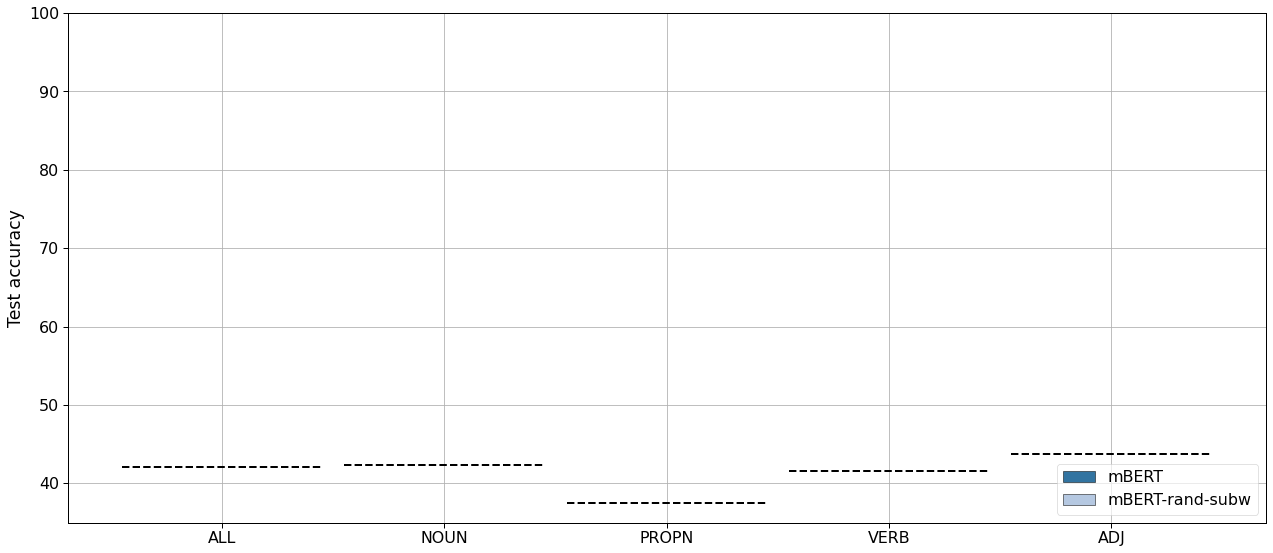

In [37]:
model_order = ['mBERT'] + model_perturbations + baseline_models
with sns.plotting_context('paper', font_scale=1.8):
    fig, ax = plt.subplots(1, figsize=(18, 8), facecolor='w')
    sns.barplot(x=b.pos, y=b.test_acc, hue=b.model, hue_order=model_order, 
                palette='tab20',
                ci=None,
                edgecolor='black', linewidth=.5, ax=ax)
    ax.set_ylim(35, 100)
    ax.set_xlabel("")
    ax.set_ylabel("Test accuracy")
    ax.grid(True)
    ax.legend(title="", loc='lower right', framealpha=0.7, fancybox=True)
    
    for pi, p in enumerate(pos_order):
        yval = majority.loc[p]
        ax.plot((pi-0.45, pi+0.45), (yval, yval), linestyle='dashed', linewidth=2, color='black')
        
    plt.tight_layout()
    fig.savefig(f"{figure_dir}/bar_bert_modeling_perturbations_by_pos.pdf", dpi=600)

# Data perturbations

In [38]:
models = ['mBERT'] + data_perturbations + baseline_models

baselines = exps[
    ((exps.model.isin(baseline_models)) & (exps.perturbation.isnull())) |
    ((exps.model=='mBERT') & (exps.perturbation.isnull())) |
    ((exps.model=='mBERT') & (exps.perturbation.isin(data_perturbations)))
]
baselines = baselines[baselines['probing_location_better']==True].copy()

In [39]:
baselines['model2'] = None

baselines.loc[(baselines['model']=='mBERT') & (baselines['perturbation'].isnull()), 'model2'] = 'mBERT'
baselines.loc[(baselines['model']=='mBERT') & (baselines['perturbation'].isin(data_perturbations)), 'model2'] = \
    baselines.loc[(baselines['model']=='mBERT') & (baselines['perturbation'].isin(data_perturbations)), 'perturbation']
baselines.loc[((baselines.model.isin(baseline_models)) & (baselines.perturbation.isnull())), 'model2'] = \
    baselines.loc[((baselines.model.isin(baseline_models)) & (baselines.perturbation.isnull())), 'model']

In [40]:
baselines['model'] = baselines['model2']

In [41]:
if set(baselines['model'].unique()) != set(models):
    raise ValueError(f"Models missing from data?\n{baselines['model'].unique()} vs. {models}")

In [42]:
b = baselines.groupby(['model', 'language', 'task'])[['dev_acc', 'test_acc']].mean()
b.name = 'test_acc'
b = b.reset_index()
b.groupby('model').mean().sort_values('test_acc')

,dev_acc,test_acc
model,,
mBERT,0.950541,0.932582


0.0

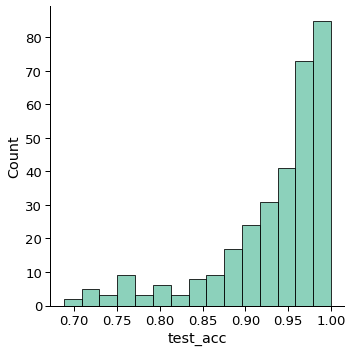

In [43]:
bert = b[b.model=='mBERT']
bert[bert['test_acc']>=99]
sns.displot(bert['test_acc'])
(bert['test_acc']>=95).mean()

In [23]:
#d = b.pivot_table(index=['language', 'task'], columns='model', values='test_acc')

In [24]:
b = baselines.groupby(['model', 'language', 'task'])[['dev_acc', 'test_acc']].mean()
b.name = 'test_acc'
b = b.reset_index()
b['pos'] = b['task'].apply(lambda t: t.split('_')[1])

all_mean = b.groupby('model').mean().reset_index()
all_mean['pos'] = 'ALL'

b = b.groupby(['model', 'pos']).mean().reset_index()

b = pd.concat((b, all_mean))
b.pos = b.pos.str.upper()

pos_order = ['ALL', 'NOUN', 'PROPN', 'VERB', 'ADJ']

b.pos = pd.Categorical(b.pos, ordered=True, categories=pos_order)

## Bar chart

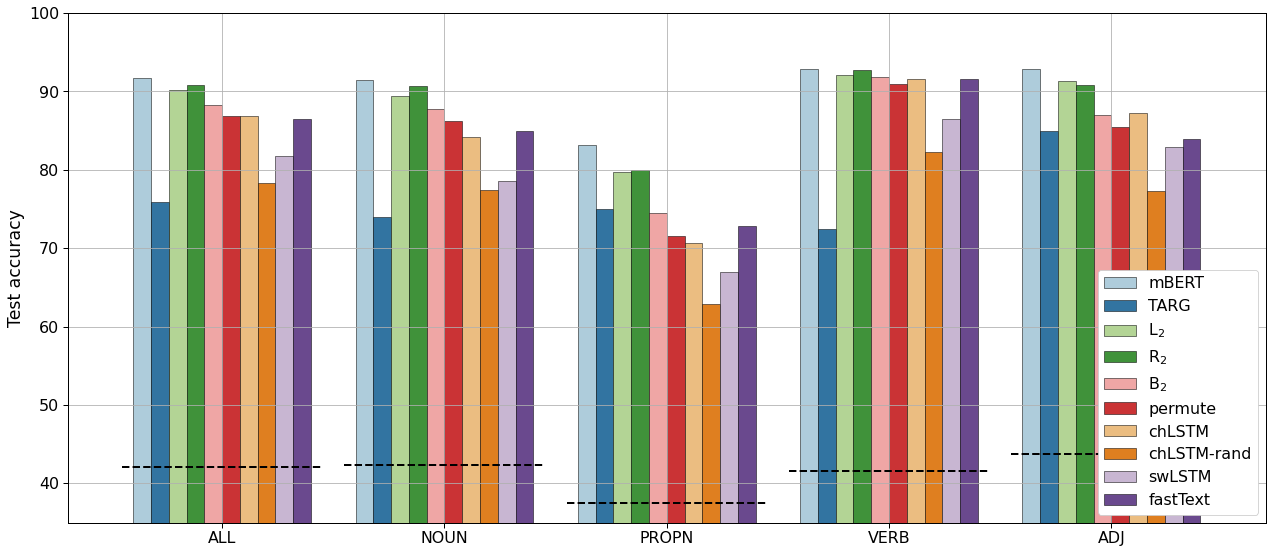

In [25]:
tab20 = sns.color_palette('tab20')
palette = [tab20[0], tab20[10], tab20[11], tab20[18], tab20[19], tab20[14], tab20[15], tab20[7], tab20[8]]
model_order = ['mBERT'] + data_perturbations + baseline_models
with sns.plotting_context('paper', font_scale=1.8):
    fig, ax = plt.subplots(1, figsize=(18, 8), facecolor='w')
    sns.barplot(x=b.pos, y=b.test_acc, hue=b.model, hue_order=model_order, 
                palette='Paired',
                ci=None,
                edgecolor='black', linewidth=.5, ax=ax)
    ax.set_ylim(35, 100)
    ax.set_xlabel("")
    ax.set_ylabel("Test accuracy")
    ax.grid(True)
    ax.legend(title="", loc='lower right', framealpha=1, fancybox=True)
    
    for pi, p in enumerate(pos_order):
        yval = majority.loc[p]
        ax.plot((pi-0.45, pi+0.45), (yval, yval), linestyle='dashed', linewidth=2, color='black')
        
    plt.tight_layout()
    fig.savefig(f"{figure_dir}/bar_bert_data_perturbations_by_pos.pdf", dpi=600)

# Results


## Tokenization

mBERT-char

In [26]:
df = exps[
    ((exps['perturbation']=='mBERT-char') |
    ((exps['model']=='mBERT') & (exps['perturbation'].isnull()))
    ) &
    (exps['probing_location_better'])
].groupby(['family', 'language', 'task', 'perturbation'], dropna=False).test_acc.mean()
df = df.reset_index()
df['perturbation'] = df['perturbation'].fillna('mBERT')
df = df.rename(columns={'perturbation': 'model'})
means = df.groupby('model').mean()
means.loc['mBERT'] - means.loc['mBERT-char']

test_acc    7.656328
dtype: float64

In [27]:
d = df.groupby(['family', 'language', 'task', 'model']).test_acc.mean().unstack()
diff_col_name = 'mBERT - mBERT-char'
d[diff_col_name] = d['mBERT'] - d['mBERT-char']
d = d.reset_index()
d = d.merge(fertility, on=['language', 'task'])
d.corr().loc[diff_col_name].sort_values()

mBERT-char                  -0.816986
mBERT                       -0.348300
majority_baseline           -0.316790
sentence_word_len           -0.031104
target_fertility             0.012832
sentence_subword_len         0.030565
sentence_fertility           0.075387
sentence_char_len            0.145515
first_entropy                0.153466
target_subw_entropy          0.153466
sentence_char_per_subword    0.166873
target_char_len              0.168313
target_char_per_subword      0.170472
last_entropy                 0.409735
mBERT - mBERT-char           1.000000
Name: mBERT - mBERT-char, dtype: float64

In [28]:
d.corr()[diff_col_name].sort_values()

mBERT-char                  -0.816986
mBERT                       -0.348300
majority_baseline           -0.316790
sentence_word_len           -0.031104
target_fertility             0.012832
sentence_subword_len         0.030565
sentence_fertility           0.075387
sentence_char_len            0.145515
first_entropy                0.153466
target_subw_entropy          0.153466
sentence_char_per_subword    0.166873
target_char_len              0.168313
target_char_per_subword      0.170472
last_entropy                 0.409735
mBERT - mBERT-char           1.000000
Name: mBERT - mBERT-char, dtype: float64

In [29]:
d.groupby(['language']).mean().sort_values(diff_col_name)

,mBERT,mBERT-char,mBERT - mBERT-char,first_entropy,last_entropy,majority_baseline,sentence_char_len,sentence_char_per_subword,sentence_fertility,sentence_subword_len,sentence_word_len,target_char_len,target_char_per_subword,target_fertility,target_subw_entropy
language,,,,,,,,,,,,,,,
Catalan,98.956250,96.438738,2.517512,9.033923,7.267638,46.525990,118.708903,3.061730,1.446146,38.779389,26.943788,8.305481,3.542712,2.557184,9.033923
Romanian,91.691915,89.068159,2.623756,8.778845,7.041988,42.963930,103.485233,2.522710,1.794445,40.804740,22.976610,7.801813,2.835670,2.997170,8.778845
Urdu,85.975000,83.250000,2.725000,7.258230,7.218278,57.125000,92.870000,2.056270,1.762899,45.386771,25.751979,5.355313,2.007779,2.923542,7.258230
Hebrew,88.659901,85.884236,2.775665,5.210270,7.720722,42.857143,84.328887,2.011605,2.045988,42.057364,20.666230,5.049803,1.970029,2.764939,5.210270
Spanish,96.814286,93.714286,3.100000,9.438418,7.544925,43.500000,118.021310,3.425491,1.349437,34.474286,25.807798,8.576012,3.791639,2.495179,9.438418
Albanian,84.935714,81.571429,3.364286,8.849349,7.248655,46.214286,82.110910,2.480596,1.799899,32.770953,18.374647,7.719866,2.858888,2.939421,8.849349
Bulgarian,95.165174,91.611488,3.553686,7.384679,6.994835,46.754184,81.783887,2.479598,1.913988,32.638369,17.226783,8.167693,2.665630,3.280597,7.384679
Afrikaans,94.750000,91.000000,3.750000,8.491142,7.551915,50.000000,127.413750,3.001271,1.731115,42.552500,24.793750,10.723333,3.508751,3.307917,8.491142
Estonian,95.650274,91.630942,4.019333,8.405924,6.373816,39.587159,105.092264,2.615394,2.242909,39.909093,17.900749,8.959328,2.794038,3.308019,8.405924


### mBERT-rand-char vs mBERT-rand-subw

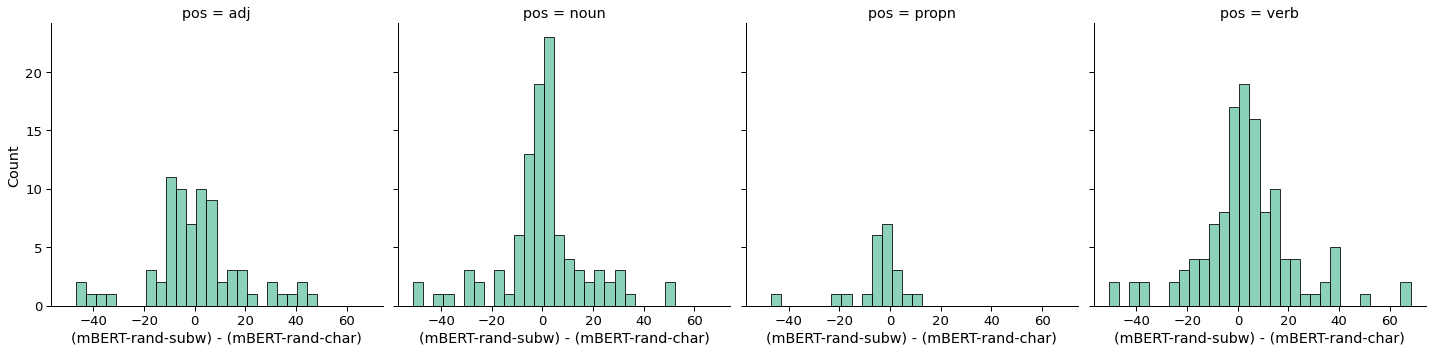

In [30]:
df = exps[
    (exps.model=='mBERT') &
    (exps.probing_location_better) &
    (exps.perturbation.isin(('mBERT-rand-char', 'mBERT-rand-subw')))
].groupby(['pos', 'language', 'task', 'perturbation'])['test_acc'].mean().unstack().reset_index()
diff_col_name = '(mBERT-rand-subw) - (mBERT-rand-char)'
df[diff_col_name] = df['mBERT-rand-subw'] - df['mBERT-rand-char']
sns.displot(data=df, x=diff_col_name, col='pos')

In [31]:
df.groupby('language')[diff_col_name].mean().sort_values()

language
Hebrew              -16.437931
Arabic              -12.917910
Dutch               -11.613184
English             -10.500000
French              -10.499083
Norwegian_Nynorsk    -9.708600
Swedish              -5.437500
Bulgarian            -5.434871
Portuguese           -5.375000
German               -4.405020
Armenian             -4.333333
Serbian              -3.575871
Albanian             -3.500000
Norwegian_Bokmal     -3.443852
Polish               -0.772189
Afrikaans            -0.500000
Hindi                -0.250000
Catalan               0.113861
Italian               0.875000
Urdu                  1.125000
Estonian              1.709721
Slovak                2.568042
Ukrainian             2.994163
Danish                3.001990
Basque                3.245614
Slovenian             3.611593
Spanish               3.714286
Czech                 4.470251
Latvian               4.557836
Russian               5.030019
Romanian              5.347015
Croatian              6.887569

In [32]:
df.merge(fertility, on=['language', 'task']).corr()[diff_col_name].sort_values()

mBERT-rand-char                         -0.442597
last_entropy                            -0.157692
majority_baseline                       -0.120415
target_char_per_subword                 -0.073155
sentence_char_per_subword               -0.061243
sentence_word_len                       -0.059639
first_entropy                           -0.056894
target_subw_entropy                     -0.056894
sentence_char_len                        0.064897
sentence_subword_len                     0.086750
target_char_len                          0.185570
sentence_fertility                       0.197477
target_fertility                         0.225367
mBERT-rand-subw                          0.409424
(mBERT-rand-subw) - (mBERT-rand-char)    1.000000
Name: (mBERT-rand-subw) - (mBERT-rand-char), dtype: float64

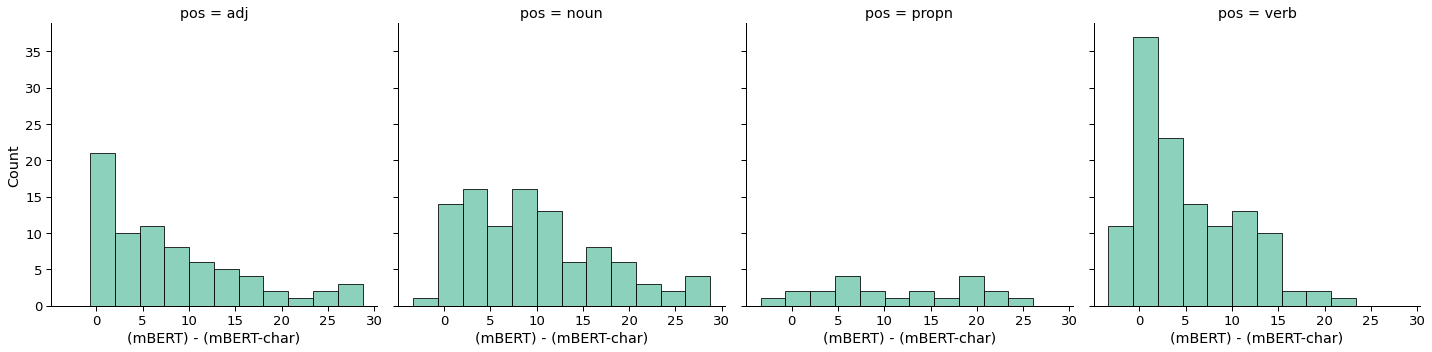

In [33]:
df = exps[
    (exps.model=='mBERT') &
    (exps.probing_location_better) &
    ((exps.perturbation=='mBERT-char') | (exps.perturbation.isnull()))
].copy()
df['perturbation'] = df['perturbation'].fillna('mBERT')
df = df.groupby(['pos', 'language', 'task', 'perturbation'])['test_acc'].mean().unstack().reset_index()
diff_col_name = '(mBERT) - (mBERT-char)'
df[diff_col_name] = df['mBERT'] - df['mBERT-char']
sns.displot(data=df, x=diff_col_name, col='pos')

In [34]:
df.groupby('language')[diff_col_name].mean().sort_values()

language
Catalan               2.517512
Romanian              2.623756
Urdu                  2.725000
Hebrew                2.775665
Spanish               3.100000
Albanian              3.364286
Bulgarian             3.553686
Afrikaans             3.750000
Estonian              4.019333
Latvian               4.214490
Italian               4.681250
Portuguese            4.787500
Danish                5.438358
Latin                 5.469861
Norwegian_Bokmal      5.482445
Basque                5.949761
English               5.983333
Norwegian_Nynorsk     6.176901
Arabic                6.453483
Hindi                 6.633333
Turkish               6.829291
French                6.963310
Swedish               6.981250
Persian               7.200000
Greek                 8.794428
Lithuanian            8.807108
Hungarian             8.816667
Czech                 8.816800
Slovak                8.982870
Croatian              9.048575
Polish                9.533227
Armenian             10.200000

In [35]:
df.merge(fertility, on=['language', 'task']).corr()[diff_col_name].sort_values()

mBERT-char                  -0.816986
mBERT                       -0.348300
majority_baseline           -0.316790
sentence_word_len           -0.031104
target_fertility             0.012832
sentence_subword_len         0.030565
sentence_fertility           0.075387
sentence_char_len            0.145515
first_entropy                0.153466
target_subw_entropy          0.153466
sentence_char_per_subword    0.166873
target_char_len              0.168313
target_char_per_subword      0.170472
last_entropy                 0.409735
(mBERT) - (mBERT-char)       1.000000
Name: (mBERT) - (mBERT-char), dtype: float64

<AxesSubplot:xlabel='language', ylabel='test_acc'>

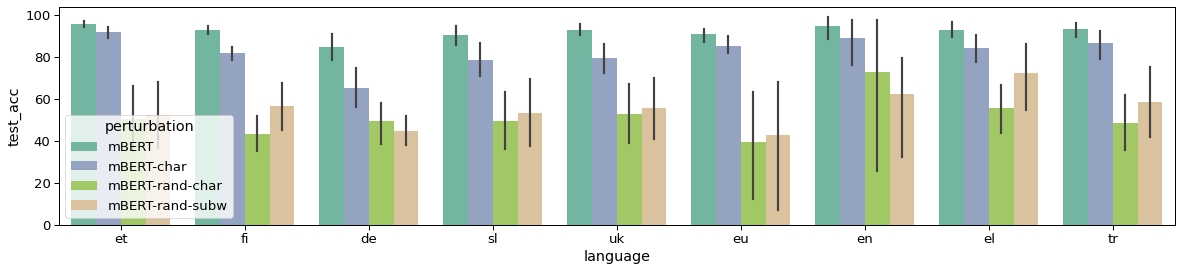

In [36]:
df = exps[
    (exps.model=='mBERT') &
    (exps.probing_location_better) &
    ((exps.perturbation.isin(('mBERT-char', 'mBERT-rand-subw', 'mBERT-rand-char'))) | (exps.perturbation.isnull()))
].copy()
df['perturbation'] = df['perturbation'].fillna('mBERT')
df = df.groupby(['pos', 'language', 'task', 'perturbation'])['test_acc'].mean().reset_index()
df = df[df['language'].isin(('Finnish', 'English', 'German', 'Ukrainian' ,'Slovenian',
                             'Estonian', 'Greek', 'Basque', 'Turkish'))]
df['language'] = df['language'].apply(lambda l: lang2code[l])

fig, ax = plt.subplots(1, figsize=(20, 4))
sns.barplot(x=df['language'], y=df['test_acc'], hue=df['perturbation'], ax=ax)

In [37]:
df = exps[
    (exps.model=='mBERT') &
    (exps.probing_location_better) &
    ((exps.perturbation.isin(('mBERT-char', 'mBERT-rand-subw', 'mBERT-rand-char'))) | (exps.perturbation.isnull()))
].copy()
df['perturbation'] = df['perturbation'].fillna('mBERT')
df = df.groupby(['pos', 'language', 'task', 'perturbation'])['test_acc'].mean().unstack().reset_index()
df['diff'] = (1-df['mBERT']) / (1-df['mBERT-char'])
df['rand diff'] = (1-df['mBERT-rand-subw']) / (1-df['mBERT-rand-char'])
df['language'] = df['language'].str.replace('_', ' ')
df['language'] = df['language'].str.replace('Nynorsk', 'N')
df = df.groupby('language').mean()
top_idx = [0, 1, 2, 3, 4, -5, -4, -3, -2, -1]
top1 = df.sort_values('diff').iloc[top_idx]
top2 = df.sort_values('rand diff').iloc[top_idx]

top1 = top1.reset_index()[['language', 'diff']]
top2 = top2.reset_index()[['language', 'rand diff']]
top = pd.concat((top2, top1), axis=1)
top = top.round(3)
lines = top.to_latex(index=False).split('\n')
lines.insert(-8, '\\midrule')
with open(f"{figure_dir}/table_tokenization_diff_minmax.tex", "w") as f:
    f.write("\n".join(lines))

In [38]:
df.loc[['Urdu', 'Catalan', 'Spanish']]

perturbation,mBERT,mBERT-char,mBERT-rand-char,mBERT-rand-subw,diff,rand diff
language,,,,,,
Urdu,85.975000,83.250000,53.750000,54.875000,1.034222,1.045714
Catalan,98.956250,96.438738,78.901609,79.015470,1.028333,1.013956
Spanish,96.814286,93.714286,49.928571,53.642857,1.036084,1.104955


In [39]:
df['ratio'] = df['diff'] / df['rand diff']

In [40]:
df.sort_values('ratio')

perturbation,mBERT,mBERT-char,mBERT-rand-char,mBERT-rand-subw,diff,rand diff,ratio
language,,,,,,,
Lithuanian,91.140441,82.333333,52.286765,61.536765,1.109448,1.706740,0.650039
Finnish,92.751736,81.526442,43.070679,56.479658,1.144003,1.437478,0.795840
Greek,92.740199,83.945771,55.499005,72.195025,1.110917,1.323658,0.839278
Turkish,93.222889,86.393599,48.463870,58.419020,1.087157,1.268296,0.857180
Russian,92.015489,81.118715,47.535045,52.565064,1.152862,1.300952,0.886168
Romanian,91.691915,89.068159,56.753980,62.100995,1.030540,1.149111,0.896815
Italian,94.743750,90.062500,61.687500,62.562500,1.054296,1.172654,0.899068
Czech,90.432583,81.615783,51.229969,55.700220,1.131592,1.255840,0.901063
Persian,95.700000,88.500000,69.000000,82.500000,1.082286,1.198529,0.903011


In [41]:
exps[(exps.language=='English')].task.unique()

array(['number_noun', 'tense_verb', 'verbform_verb'], dtype=object)

In [42]:
df.corr()['diff'].sort_values()

perturbation
mBERT-char        -0.821160
mBERT             -0.346001
mBERT-rand-char   -0.257895
mBERT-rand-subw   -0.243128
rand diff          0.129330
ratio              0.235394
diff               1.000000
Name: diff, dtype: float64